In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Directories
results_dir = Path("results")
figures_dir = results_dir / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

print(f"Results directory: {results_dir}")
print(f"Figures directory: {figures_dir}")

Results directory: results
Figures directory: results/figures


In [3]:
# Load grid search results
grid_results_path = results_dir / "grid_search_results.json"

if grid_results_path.exists():
    with open(grid_results_path, 'r') as f:
        grid_results = json.load(f)
    print(f"Loaded {len(grid_results)} grid search configurations")
    results_df = pd.DataFrame(grid_results)
    display(results_df.head())
else:
    print(f"Grid search results not found at {grid_results_path}")
    print("Run the grid search in CS229_ProjectionLayer.ipynb first.")
    grid_results = []
    results_df = pd.DataFrame()

Loaded 30 grid search configurations


,label,batch_size,temperature,weights,triplet_acc,best_loss,epochs_trained,train_time_sec,pos_pairs,easy_pairs,hard_pairs
0,structure_boost_bs96_t0.70_spe4000,96,0.7,"{'name': 'structure_boost', 'alpha': 0.5, 'bet...",0.804348,3.755997,219,67.303765,17065,16629,0
1,structure_boost_bs96_t0.50_spe4000,96,0.5,"{'name': 'structure_boost', 'alpha': 0.5, 'bet...",0.782609,3.513513,217,66.969710,17065,16629,0
2,semantic_push_bs96_t0.70_spe4000,96,0.7,"{'name': 'semantic_push', 'alpha': 0.45, 'beta...",0.782609,3.719672,200,61.294393,17065,17017,0
3,semantic_push_bs128_t0.50_spe4000,128,0.5,"{'name': 'semantic_push', 'alpha': 0.45, 'beta...",0.739130,3.726461,231,55.575785,17065,17017,0
4,balanced_bs128_t0.70_spe4000,128,0.7,"{'name': 'balanced', 'alpha': 0.55, 'beta_emo'...",0.739130,4.014744,174,41.382290,17065,16594,0


In [4]:
# MPNet baseline accuracy
MPNET_BASELINE_ACCURACY = 0.6739  # 67.39% (31/46 comparisons)

print(f"MPNet baseline accuracy: {MPNET_BASELINE_ACCURACY*100:.2f}%")

MPNet baseline accuracy: 67.39%


## Placeholder for Visualizations

Graphs and plots will be added below based on user requirements.

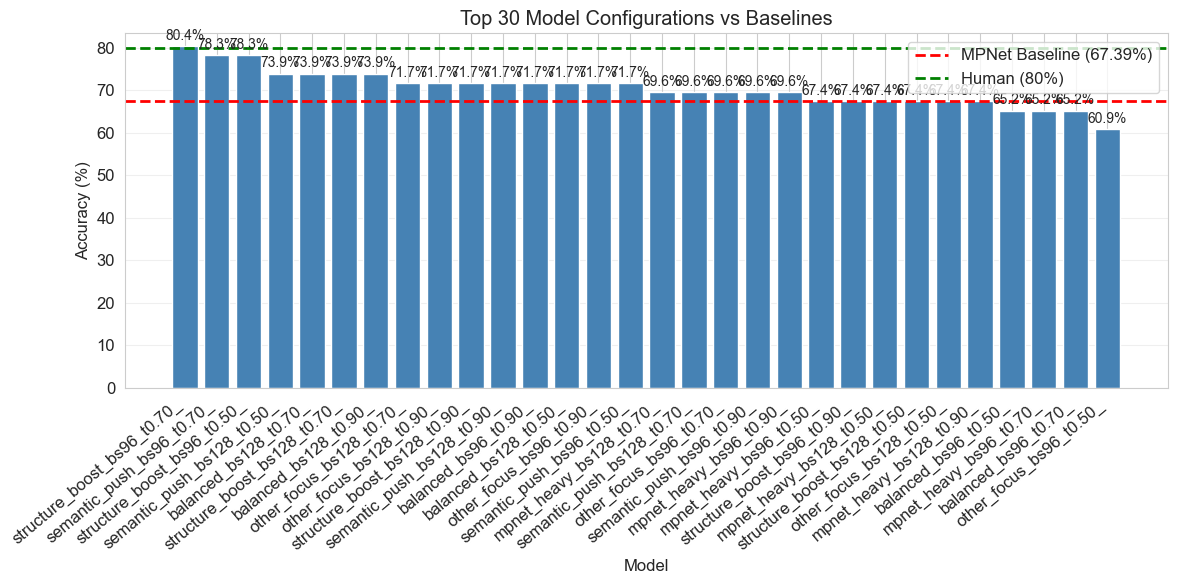

In [14]:
# Top-N Configurations by Accuracy (Prettier vertical chart)
TOP_N = 30  # ← Change this to show more/fewer top models
HUMAN_BASELINE_ACCURACY = 0.80  # 80%

if not results_df.empty:
    # Sort by accuracy and take top N
    top_results = results_df.nlargest(TOP_N, 'triplet_acc').copy()

    # Build prettier display labels from `label`, removing noisy tokens like 'spe4000'
    def prettify_label(s: str, max_len: int = 32):
        s = str(s)
        s = s.replace('spe4000', '').strip()
        # Collapse multiple spaces
        s = ' '.join(s.split())
        # Truncate long labels with ellipsis
        return (s[:max_len] + '…') if len(s) > max_len else s

    display_labels = [prettify_label(lbl) for lbl in top_results['label']]

    # Figure size scales with number of bars for readability
    fig_width = max(12, int(TOP_N * 0.4))
    fig, ax = plt.subplots(figsize=(fig_width, 6))

    x = np.arange(len(top_results))
    heights = top_results['triplet_acc'].values * 100

    bars = ax.bar(x, heights, color='steelblue')

    # Axes and title
    ax.set_xticks(x)
    ax.set_xticklabels(display_labels)
    plt.setp(ax.get_xticklabels(), rotation=40, ha='right')
    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Model')
    ax.set_title(f'Top {TOP_N} Model Configurations vs Baselines')

    # Baseline reference lines
    ax.axhline(MPNET_BASELINE_ACCURACY * 100, color='red', linestyle='--', linewidth=2,
               label='MPNet Baseline (67.39%)')
    ax.axhline(HUMAN_BASELINE_ACCURACY * 100, color='green', linestyle='--', linewidth=2,
               label='Human (80%)')

    # Value labels above bars
    y_max = heights.max() if len(heights) else 100
    ax.set_ylim(0, y_max + 3)
    for i, h in enumerate(heights):
        ax.text(i, h + 0.8, f'{h:.1f}%', ha='center', va='bottom', fontsize=10)

    # Styling
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'top_n_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No results to plot. Run grid search first.")

/var/folders/ty/n80_fyn54pg4r8r094nnt5100000gn/T/ipykernel_79841/2105898980.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_batch, labels=batch_sizes, patch_artist=True)


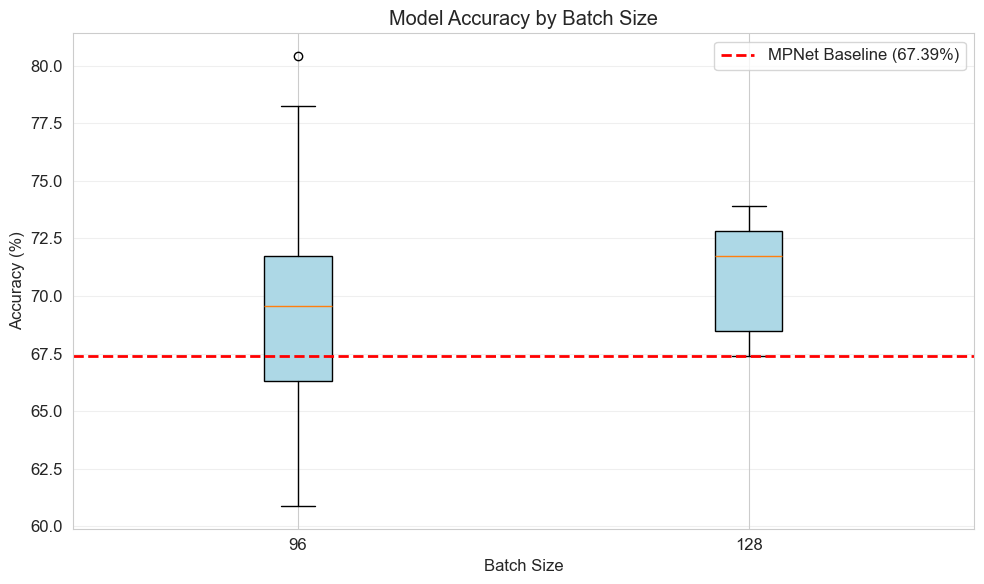

In [12]:
# Batch Size Comparison
if not results_df.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Group by batch size
    batch_sizes = sorted(results_df['batch_size'].unique())
    data_by_batch = [results_df[results_df['batch_size'] == bs]['triplet_acc'].values * 100 
                     for bs in batch_sizes]
    
    # Create box plot
    bp = ax.boxplot(data_by_batch, labels=batch_sizes, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    # Add MPNet baseline line
    ax.axhline(MPNET_BASELINE_ACCURACY * 100, color='red', linestyle='--', 
               linewidth=2, label='MPNet Baseline (67.39%)')
    
    ax.set_xlabel('Batch Size')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model Accuracy by Batch Size')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'batch_size_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No results to plot. Run grid search first.")

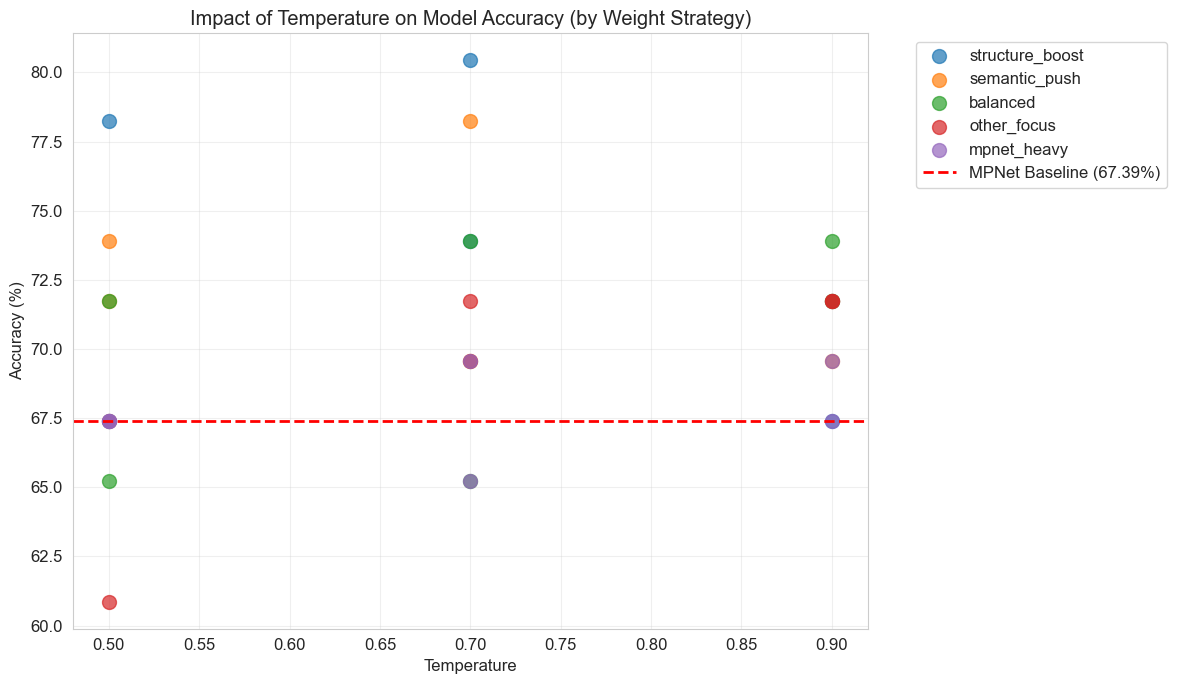

In [7]:
# ===== PLOT 3: Temperature Impact =====
if not results_df.empty:
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Get unique weight strategies (from weights 'name' field)
    results_df['strategy'] = results_df['weights'].apply(lambda w: w.get('name', 'Unknown'))
    strategies = results_df['strategy'].unique()
    
    # Color map for strategies
    colors = plt.cm.tab10(range(len(strategies)))
    strategy_colors = dict(zip(strategies, colors))
    
    # Scatter plot with different colors for each strategy
    for strategy in strategies:
        strategy_df = results_df[results_df['strategy'] == strategy]
        ax.scatter(strategy_df['temperature'], strategy_df['triplet_acc'] * 100, 
                  label=strategy, alpha=0.7, s=100, color=strategy_colors[strategy])
    
    # Add MPNet baseline line
    ax.axhline(MPNET_BASELINE_ACCURACY * 100, color='red', linestyle='--', 
               linewidth=2, label='MPNet Baseline (67.39%)')
    
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Impact of Temperature on Model Accuracy (by Weight Strategy)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(figures_dir / 'temperature_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No results to plot. Run grid search first.")

/var/folders/ty/n80_fyn54pg4r8r094nnt5100000gn/T/ipykernel_79841/2122751081.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_strategy, labels=strategies, patch_artist=True)


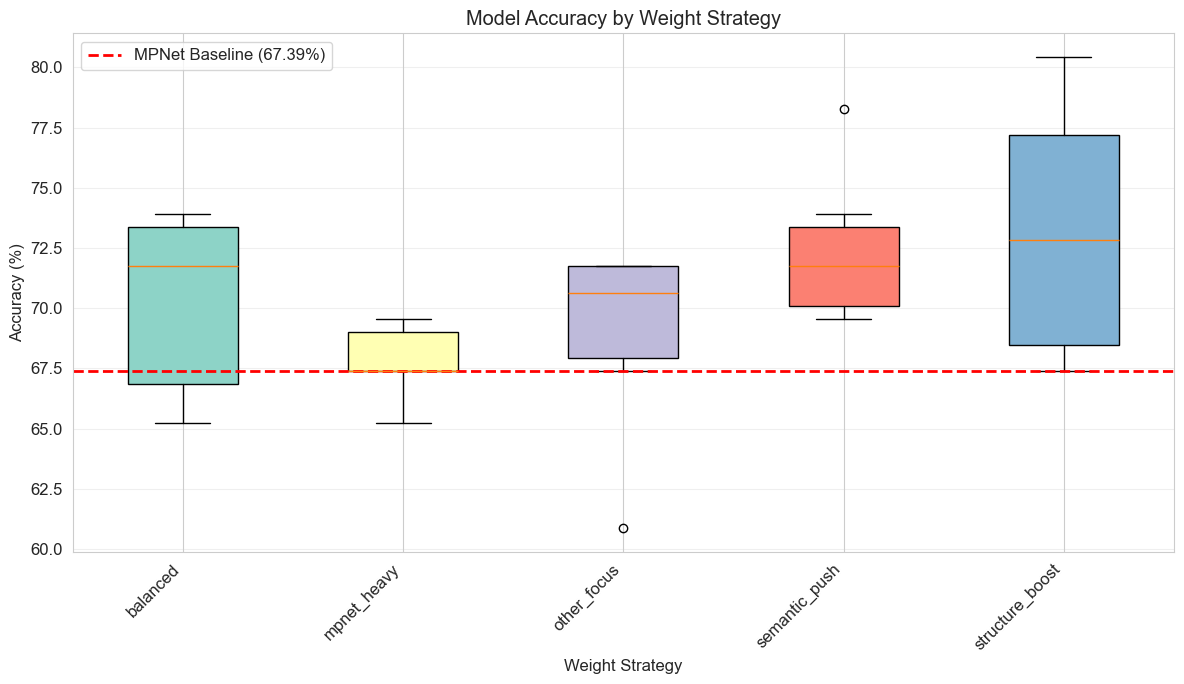

In [8]:
# PLOT 4: Weight Strategy Comparison
if not results_df.empty:
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Ensure strategy column exists
    if 'strategy' not in results_df.columns:
        results_df['strategy'] = results_df['weights'].apply(lambda w: w.get('name', 'Unknown'))
    
    # Group by strategy
    strategies = sorted(results_df['strategy'].unique())
    data_by_strategy = [results_df[results_df['strategy'] == s]['triplet_acc'].values * 100 
                        for s in strategies]
    
    # Create box plot
    bp = ax.boxplot(data_by_strategy, labels=strategies, patch_artist=True)
    colors = plt.cm.Set3(range(len(strategies)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Add MPNet baseline line
    ax.axhline(MPNET_BASELINE_ACCURACY * 100, color='red', linestyle='--', 
               linewidth=2, label='MPNet Baseline (67.39%)')
    
    ax.set_xlabel('Weight Strategy')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model Accuracy by Weight Strategy')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(figures_dir / 'weight_strategy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No results to plot. Run grid search first.")

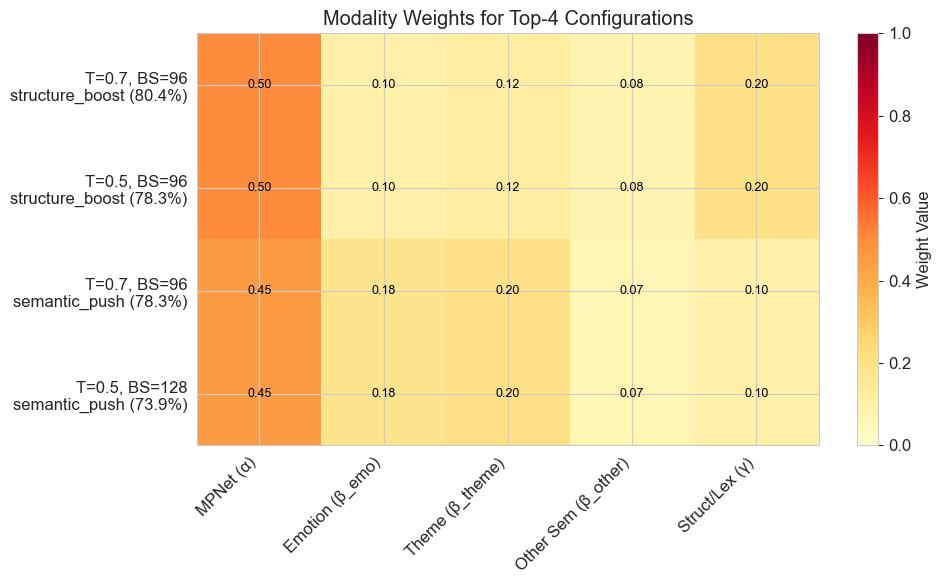

In [9]:
#  Modality Weight Heatmap for Top-5 Configs 
TOP_K_HEATMAP = 4  # ← Change this to see more/fewer configs

if not results_df.empty:
    # Get top K configurations
    top_k = results_df.nlargest(TOP_K_HEATMAP, 'triplet_acc').copy()
    
    # Extract weight components
    weight_components = []
    config_labels = []
    
    for idx, row in top_k.iterrows():
        weights = row['weights']
        # Extract individual weights (alpha, beta_emo, beta_theme, beta_other, gamma)
        alpha = weights.get('alpha', 0)
        beta_emo = weights.get('beta_emo', 0)
        beta_theme = weights.get('beta_theme', 0)
        beta_other = weights.get('beta_other', 0)
        gamma = weights.get('gamma', 0)
        
        weight_components.append([alpha, beta_emo, beta_theme, beta_other, gamma])
        
        # Create label with key hyperparameters
        label = f"T={row['temperature']}, BS={row['batch_size']}\n{weights.get('name', 'Config')} ({row['triplet_acc']*100:.1f}%)"
        config_labels.append(label)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, max(6, TOP_K_HEATMAP * 0.8)))
    
    weight_matrix = np.array(weight_components)
    im = ax.imshow(weight_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    
    # Set ticks and labels
    ax.set_xticks(range(5))
    ax.set_xticklabels(['MPNet (α)', 'Emotion (β_emo)', 'Theme (β_theme)', 
                        'Other Sem (β_other)', 'Struct/Lex (γ)'], rotation=45, ha='right')
    ax.set_yticks(range(len(config_labels)))
    ax.set_yticklabels(config_labels)
    
    # Add text annotations
    for i in range(len(config_labels)):
        for j in range(5):
            text = ax.text(j, i, f'{weight_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=9)
    
    ax.set_title(f'Modality Weights for Top-{TOP_K_HEATMAP} Configurations')
    plt.colorbar(im, ax=ax, label='Weight Value')
    plt.tight_layout()
    plt.savefig(figures_dir / 'modality_weight_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No results to plot. Run grid search first.")